In [117]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import h_transport_materials as htm

# another github test

In [118]:
c0 = sp.Symbol("c_0", positive=True)
L = sp.Symbol("L", positive=True)
x = sp.Symbol("x", positive=True)
t = sp.Symbol("t", positive=True)
D = sp.Symbol("D", positive=True)
n = sp.Symbol("n", integer=True, positive=True)

c = sp.Function("c")(x, t)


The local concentration of hydrogen in the salt can be expressed as:

In [119]:
integral = c0 * L * (1 - sp.sin(sp.pi * n)/(sp.pi * n))

f = 0
c_E_x = c0*(1-x/L)

integral = sp.integrate((f-c_E_x)*sp.sin(n*sp.pi*x/L), (x, 0, L))

Bn = 2/L * integral
infinite_sum = sp.Sum(Bn * sp.sin(n*sp.pi*x/L) * sp.exp(-D*(n*sp.pi/L)**2 * t), (n, 1, sp.oo))

c_expr = c0 * (1 - x/L) + infinite_sum
sp.Eq(c, c_expr)

Eq(c(x, t), c_0*(1 - x/L) + Sum(-2*c_0*exp(-pi**2*D*n**2*t/L**2)*sin(pi*n*x/L)/(pi*n), (n, 1, oo)))

The dowstream flux is expressed as:

$$\mathrm{dowstream \ flux} = -D\nabla c |_{x=L}$$

In [120]:
flux_expr = -D*sp.diff(c_expr, x).subs(x, L)
flux_expr.simplify()

D*c_0*(2*Sum((-1)**n*exp(-pi**2*D*n**2*t/L**2), (n, 1, oo)) + 1)/L

Expressing the concentration on the upstream surface $c_0$ from Henry's law of solubility and introducing the permeability $\Phi$, the downstream flux becomes:

In [121]:
K_H = sp.Symbol("K_H")
P_up = sp.Symbol("P_\mathrm{up}")
perm = sp.Symbol("\Phi")

flux_expr = flux_expr.subs(c0, K_H * P_up).simplify()
flux_expr = flux_expr.subs(D*K_H, perm).simplify()
flux_expr

P_\mathrm{up}*\Phi*(2*Sum((-1)**n*exp(-pi**2*D*n**2*t/L**2), (n, 1, oo)) + 1)/L

In [122]:
def downstream_flux(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up * permeability / L * (2*summation + 1)



In [123]:
def sweep_gas_concentration(flux, area, gas_flow):
    return flux*area/gas_flow

This is the design of HYPERION 6/16/2023

<img width="1055" alt="image" src="https://github.com/RemDelaporteMathurin/hyperion/assets/40028739/7772f7ec-649a-4a0b-8e58-9cf053cbdbe2">

In [124]:
htm.ureg.define('fraction = [] = frac')
htm.ureg.define('ppm = 1e-6 fraction')

MOLAR_VOL_RT = 24.45 * htm.ureg.L * htm.ureg.mol**-1
MOLAR_MASS_H2 = 2.016 * htm.ureg.g * htm.ureg.mol**-1

sweep_rate = 20 * htm.ureg.cm**3 * htm.ureg.min**-1
L = 0.4*htm.ureg.inches
diam = 4*htm.ureg.inches
area = np.pi * (diam/2) ** 2

temperature_range = [760, 970] * htm.ureg.K


In [125]:
flibe_diffusivity = htm.diffusivities.filter(material=htm.FLIBE).mean()
flibe_diffusivity_min = flibe_diffusivity.value(temperature_range[0])
flibe_diffusivity_max = flibe_diffusivity.value(temperature_range[1])
flibe_solubility_min = 1e17 * htm.ureg.particle * htm.ureg.m**-3 * htm.ureg.Pa**-1
flibe_solubility_max = 6.29e20 * htm.ureg.particle * htm.ureg.m**-3 * htm.ureg.Pa**-1

flibe_permeability_max = flibe_solubility_max*flibe_diffusivity_max
flibe_permeability_min = flibe_solubility_min*flibe_diffusivity_min


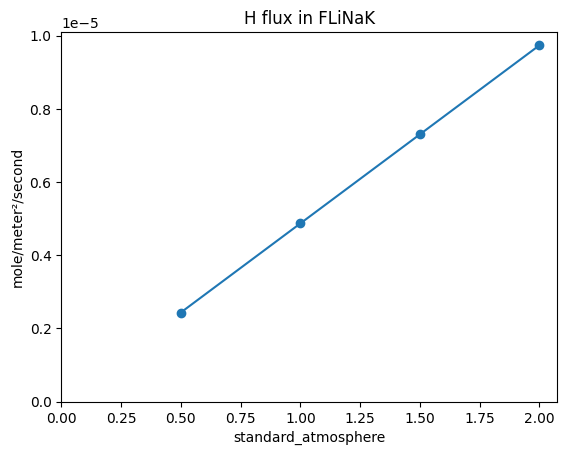

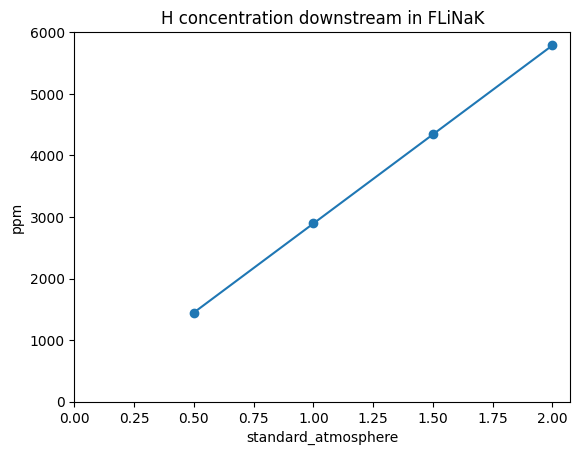

In [126]:
# Testing fluxes for FLiNaK using Fukada's data

D_fukada = htm.diffusivities.filter(material=htm.FLINAK, author='fukada')[0]
K_H_fukada = htm.solubilities.filter(material=htm.FLINAK, author='fukada')[0]
perm_fukada = htm.ArrheniusProperty(
    pre_exp=D_fukada.pre_exp*K_H_fukada.pre_exp,
    act_energy=D_fukada.act_energy+K_H_fukada.act_energy
    )
t_array = np.linspace(0, 6, num=500) * htm.ureg.h

T = (700+273.15) * htm.ureg.K
pressures = np.linspace(0.5, 2, num=4) * htm.ureg.atm
fluxes=[]
concentrations=[]

for P_up in pressures:
    flux = downstream_flux(t_array, P_up, perm_fukada.value(T), L, D_fukada.value(T))[-1]
    fluxes.append(flux)
    concentration = (flux*area)/sweep_rate*MOLAR_MASS_H2
    concentrations.append((concentration*MOLAR_VOL_RT/MOLAR_MASS_H2).to(htm.ureg.ppm))


plt.figure()
plt.plot(pressures, htm.ureg.Quantity.from_list(fluxes).to(htm.ureg.mol * htm.ureg.m**-2 * htm.ureg.s**-1), marker='o')
plt.title('H flux in FLiNaK')
plt.ylim(bottom=0)
plt.xlim(left=0)

plt.figure()
plt.plot(pressures, htm.ureg.Quantity.from_list(concentrations), marker='o')
plt.title('H concentration downstream in FLiNaK')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

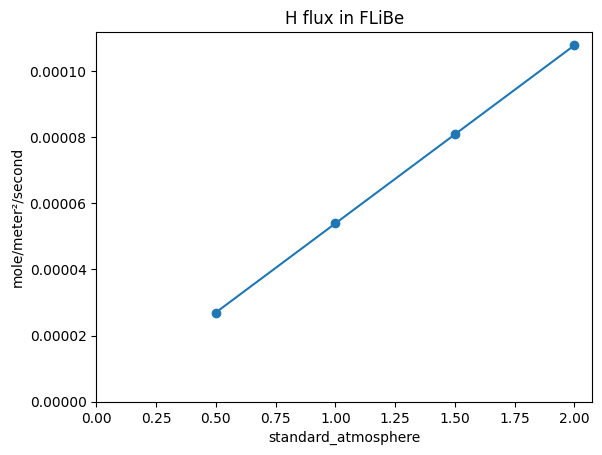

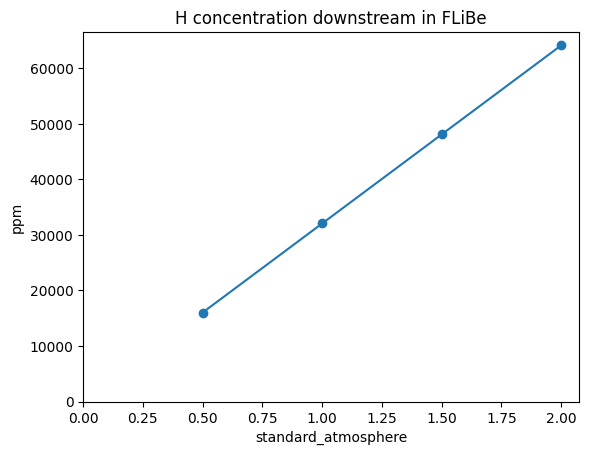

In [127]:
# Testing fluxes for FLiBe using Calderoni's data

# why using calderoni's data if its tritium?

D_calderoni = htm.diffusivities.filter(material=htm.FLIBE, author='calderoni')[0]
K_H_calderoni = htm.solubilities.filter(material=htm.FLIBE, author='calderoni')[0]
perm_calderoni = htm.ArrheniusProperty(
    pre_exp=D_calderoni.pre_exp*K_H_calderoni.pre_exp,
    act_energy=D_calderoni.act_energy+K_H_calderoni.act_energy
    )
t_array = np.linspace(0, 6, num=500) * htm.ureg.h


T = (700+273.15) * htm.ureg.K
pressures = np.linspace(0.5, 2, num=4) * htm.ureg.atm
fluxes=[]
concentrations = []
for P_up in pressures:
    flux = downstream_flux(t_array, P_up, perm_calderoni.value(T), L, D_calderoni.value(T))[-1]
    fluxes.append(flux)
    concentration = (flux*area)/sweep_rate*MOLAR_MASS_H2
    concentrations.append((concentration*MOLAR_VOL_RT/MOLAR_MASS_H2).to(htm.ureg.ppm))

plt.figure()
plt.plot(pressures, htm.ureg.Quantity.from_list(fluxes).to(htm.ureg.mol * htm.ureg.m**-2 * htm.ureg.s**-1), marker='o')
plt.title('H flux in FLiBe')
plt.ylim(bottom=0)
plt.xlim(left=0)

plt.figure()
plt.plot(pressures, htm.ureg.Quantity.from_list(concentrations), marker='o')
plt.title('H concentration downstream in FLiBe')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

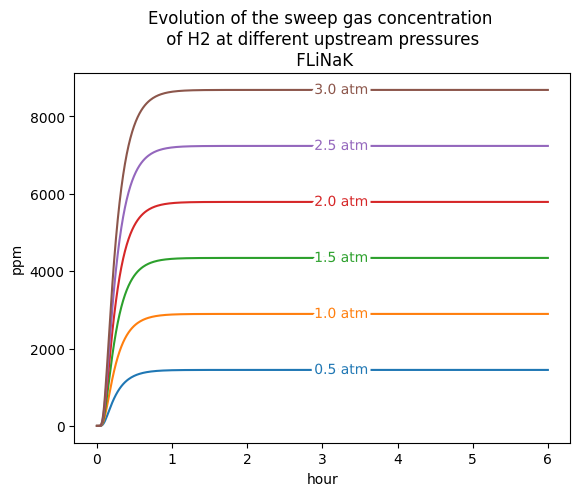

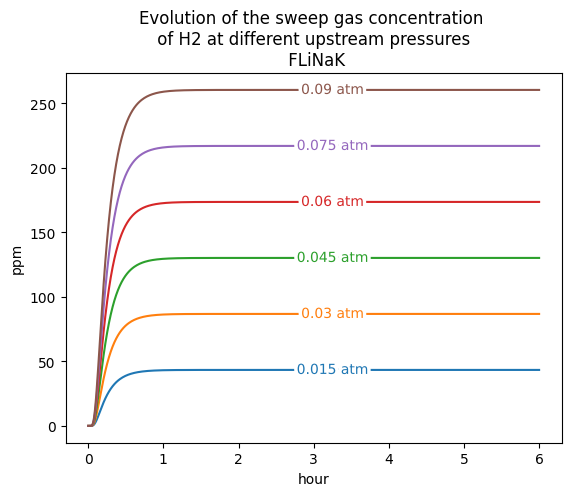

In [133]:
from labellines import labelLine, labelLines


t_array = np.linspace(0, 6, num=500) * htm.ureg.h

T = (700+273.15) * htm.ureg.K
higher_pressures = np.linspace(0.5, 3, num=6) * htm.ureg.atm # Represents pure hydrogen gas
lower_pressures = higher_pressures * 0.03 # Represents the 3% hydrogen mixture

for pressures in [higher_pressures, lower_pressures]:
    plt.figure()
    fluxes=[]
    concentrations = []
    for P_up in pressures:
        flux = downstream_flux(t_array, P_up, perm_fukada.value(T), L, D_fukada.value(T))
        concentration = ((flux*area)/sweep_rate*MOLAR_MASS_H2).to(htm.ureg.mg*htm.ureg.meter**-3)
        concentration = ((concentration*MOLAR_VOL_RT/MOLAR_MASS_H2).to(htm.ureg.ppm))
        concentration[0] = 0
        plt.plot(t_array, concentration, label=f"{P_up:~P}")
    labelLines(plt.gca().get_lines(), xvals=[3.25] * 6)
    #plt.legend()
    plt.title("Evolution of the sweep gas concentration \n of H2 at different upstream pressures \n FLiNaK")

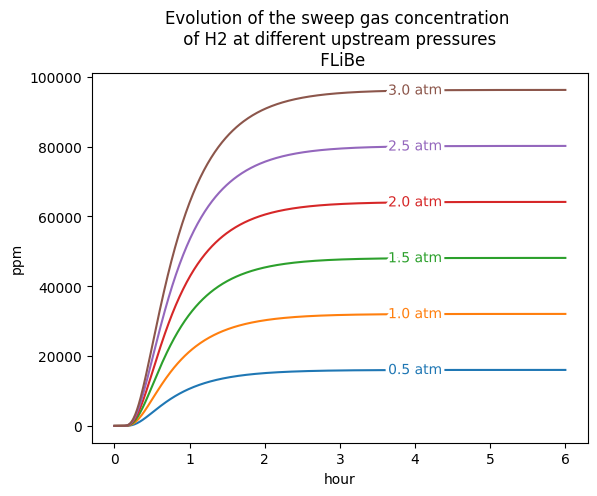

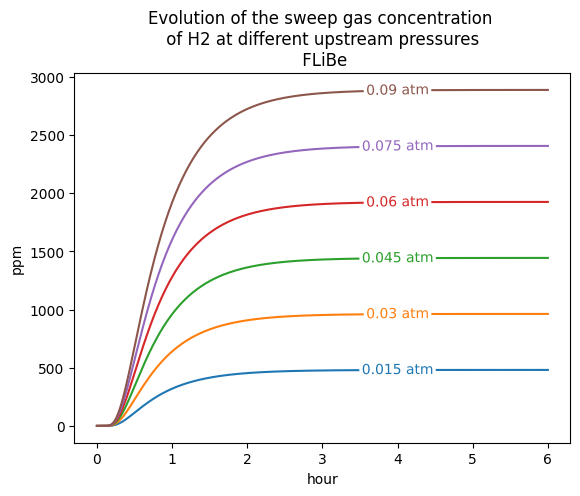

In [131]:
t_array = np.linspace(0, 6, num=500) * htm.ureg.h

T = (700+273.15) * htm.ureg.K
higher_pressures = np.linspace(0.5, 3, num=6) * htm.ureg.atm # Pure hydrogen
lower_pressures = higher_pressures * 0.03 # 3% hydrogen-argon mixture

for pressures in [higher_pressures, lower_pressures]:
    plt.figure()
    fluxes=[]
    concentrations = []
    for P_up in pressures:
        flux = downstream_flux(t_array, P_up, perm_calderoni.value(T), L, D_calderoni.value(T))
        concentration = ((flux*area)/sweep_rate*MOLAR_MASS_H2).to(htm.ureg.mg*htm.ureg.meter**-3)
        concentration = ((concentration*MOLAR_VOL_RT/MOLAR_MASS_H2).to(htm.ureg.ppm))
        concentration[0] = 0
        plt.plot(t_array, concentration, label=f"{P_up:~P}")
    labelLines(plt.gca().get_lines(), xvals=[4] * 6)\
    #plt.legend()
    plt.title("Evolution of the sweep gas concentration \n of H2 at different upstream pressures \n FLiBe")

### Now to think a little bit about deuterium and what results we should be expecting
There are no measurements for deuterium solubility and diffusivity in the literature unfortuantely, and not a lot that have measured both

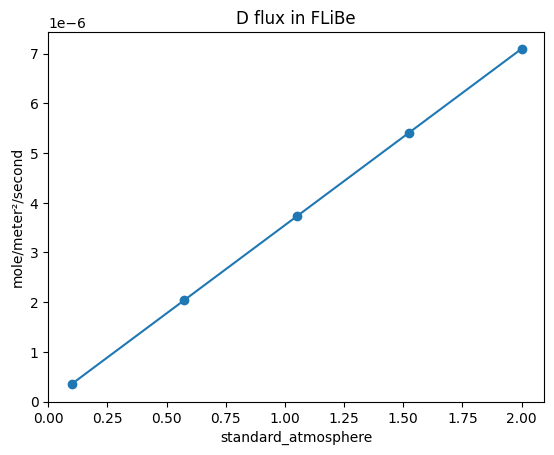

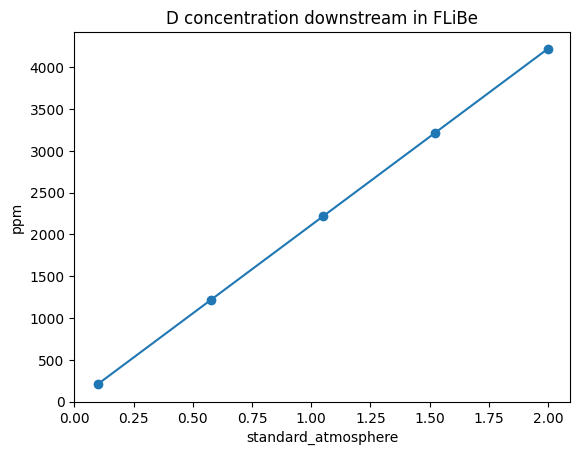

Text(0.5, 1.0, 'Evolution of the sweep gas concentration \n of D2 at different upstream pressures \n FLiBe')

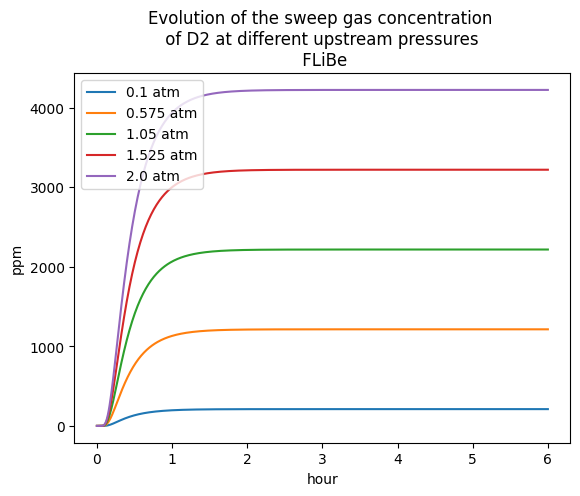

In [130]:

MOLAR_MASS_D2 = 2.014 * 2 * htm.ureg.g * htm.ureg.mol**-1

D_anderl = htm.diffusivities.filter(material=htm.FLIBE, author='anderl')[0]
K_H_anderl = htm.solubilities.filter(material=htm.FLIBE, author='anderl')[0]
perm_anderl = htm.ArrheniusProperty(
    pre_exp=D_anderl.pre_exp*K_H_anderl.pre_exp,
    act_energy=D_anderl.act_energy+K_H_anderl.act_energy
    )
t_array = np.linspace(0, 6, num=500) * htm.ureg.h

# steady-state flux graphs

T = (700+273.15) * htm.ureg.K
pressures = np.linspace(0.1, 2, num=5) * htm.ureg.atm
fluxes=[]
concentrations = []
for P_up in pressures:
    flux = downstream_flux(t_array, P_up, perm_anderl.value(T), L, D_anderl.value(T))[-1]
    fluxes.append(flux)
    concentration = (flux*area)/sweep_rate*MOLAR_MASS_D2
    concentrations.append((concentration*MOLAR_VOL_RT/MOLAR_MASS_D2).to(htm.ureg.ppm))

plt.figure()
plt.plot(pressures, htm.ureg.Quantity.from_list(fluxes).to(htm.ureg.mol * htm.ureg.m**-2 * htm.ureg.s**-1), marker='o')
plt.title('D flux in FLiBe')
plt.ylim(bottom=0)
plt.xlim(left=0)

plt.figure()
plt.plot(pressures, htm.ureg.Quantity.from_list(concentrations), marker='o')
plt.title('D concentration downstream in FLiBe')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

# transient flux graphs

fluxes=[]
concentrations = []
for P_up in pressures:
    flux = downstream_flux(t_array, P_up, perm_anderl.value(T), L, D_anderl.value(T))
    concentration = ((flux*area)/sweep_rate*MOLAR_MASS_D2).to(htm.ureg.mg*htm.ureg.meter**-3)
    concentration = ((concentration*MOLAR_VOL_RT/MOLAR_MASS_D2).to(htm.ureg.ppm))
    concentration[0] = 0
    plt.plot(t_array, concentration, label=f"{P_up:~P}")
plt.legend()
plt.title("Evolution of the sweep gas concentration \n of D2 at different upstream pressures \n FLiBe")